#**1 Introduccion**

En el siguiente cuaderno se realizara el producto entre dos matrices cuadradas[1], donde el resultado del producto es una nueva matriz. Es decir:

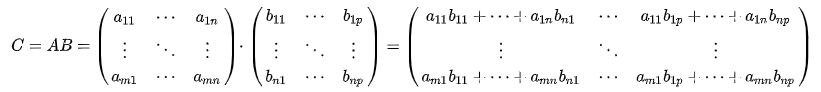

Si bien el producto entre matrices tienen la propiedad de que el número de columnas de la matriz A tiene que ser igual al número de filas de la matriz B, en este ejercicio se opto por realizar el producto solo para matrices cuadradas.

En cuanto a la descripcion de la paralelizacion[2]:

Como se ha definido cada bloque de forma bidimensional, se calculan índices de columnas y filas (después se convertirán a un índice lineal para hacer las operaciones).
Se lanzan threads, que en cada uno de ellos se generará el cálculo de su correspondiente elemento en la matriz resultante. Para poder generar éste resultado, es necesario hacer un ciclo hasta "n" para hacer la sumatoria de las multiplicaciones necesarias. Para que la asignacion de la sumatoria en la matriz resultante sea correcta se sincronizan los hilos con __syncthreads() [3].


#**2 Armando el ambiente**

Instala en el cuaderno el modulo de CUDA de python

In [ ]:
!pip install pycuda


#**3 Desarrollo**

In [ ]:
# ------------------------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

f =   3#@param {type: "number"}
c =   3#@param {type: "number"}

# ------------------------------------------------------------

import pycuda.driver as cuda
import pycuda.autoinit
from   pycuda.compiler import SourceModule

import numpy
import copy

try:
  matriz_cpu = numpy.random.random((f,c)) *10
  matriz_cpu = matriz_cpu.astype(numpy.int32())

  matriz1 = numpy.random.random((f,c)) *10
  matriz1 = matriz1.astype(numpy.int32())

  matriz_r = numpy.random.random((f,c)) *10
  matriz_r = matriz_r.astype(numpy.int32())

  matriz_gpu = cuda.mem_alloc(matriz_cpu.nbytes)
  matriz1_gpu = cuda.mem_alloc(matriz1.nbytes)
  matrizr_gpu = cuda.mem_alloc(matriz_r.nbytes)

  cuda.memcpy_htod(matriz_gpu,matriz_cpu)
  cuda.memcpy_htod(matriz1_gpu,matriz1)
  cuda.memcpy_htod(matrizr_gpu,matriz_r)


  #CPU - Defino la funcion kernel que ejecutará en GPU
  module = SourceModule("""
  __global__ void productoMatrices(int n, int *M1, int *M2, int *MR)
  {
      int col = threadIdx.x + blockIdx.x*blockDim.x;
      int fila = threadIdx.y + blockIdx.y*blockDim.y;
      float suma=0;

      if(col<n && fila<n)
      {
        for(int k=0; k<n;k++){
        float a = M1[col*n+k];
        float b = M2[k*n+fila];
        suma+= a*b;
        }
      __syncthreads();
      MR[col*n+fila] = suma;
      }
  }

  """)

  kernel = module.get_function("productoMatrices")

  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (f+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 16
  dim_bloque_y = numpy.int( (c+dim_hilo_y-1) / dim_hilo_y )

  print( "Thread x: ", dim_hilo_x, ", Bloque x:", dim_bloque_x )
  print( "Thread y: ", dim_hilo_y, ", Bloque y:", dim_bloque_y )

  kernel( numpy.int32(f), matriz_gpu, matriz1_gpu, matrizr_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ),grid=(dim_bloque_x, dim_bloque_y,1) )
  cuda.memcpy_dtoh(matriz_r,matrizr_gpu)

  print("Matriz 1: ")
  print(matriz_cpu)
  print("Matriz 2:")
  print(matriz1)
  print("Resultado de la suma de matrices")
  print(matriz_r)

except:
  print("Error en los indices, debe ingresar valores positivos")
  exit()

Thread x:  16 , Bloque x: 1
Thread y:  16 , Bloque y: 1
Matriz 1: 
[[7 7 6]
 [5 5 9]
 [5 4 7]]
Matriz 2:
[[2 1 2]
 [7 0 3]
 [4 6 8]]
Resultado de la suma de matrices
[[87 43 83]
 [81 59 97]
 [66 47 78]]


#**4 Tabla de pasos**

 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  @param                | Lectura del tamaño de las matrices en Colab.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  numpy.random.randn( (n,n ) | Inicializa los Matrices.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copia las memorias desde el CPU al GPU.
CPU      |  SourceModule()        | Define el código del kernel 
CPU      |  module.get_function() | Genera la función del kernel GPU
CPU      |  dim_tx/dim_bx         | Calcula las dimensiones.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU
CPU      |  cuda.memcpy_dtoh( )   | Copia el resultado desde GPU memoria matrizr_gpu a CPU memoria matriz_r.
CPU      |  print()               | Informo los resultados.


#**5 Conclusion**

Se puede observar que en el producto de matrices en la GPU, debido a que un único thread se utiliza para calcular el valor de MR(i,j), la complejidad resultante[4] es O(N) que acomparacion del producto en el CPU [5] resulta ser mucho mas óptimo y por lo tanto mas rápido.


#**6 Bibliografia**

[1] Multiplicacion de Matrices: [WEB](https://es.wikipedia.org/wiki/Multiplicaci%C3%B3n_de_matrices)

[2] PyCUDA: [WEB](https://documen.tician.de/pycuda/index.html)

[3] Warps, Blocks, and Synchronization: [PDF](https://www.math.wsu.edu/math/kcooper/CUDA/13CUDAblock.pdf)

[4] Complejidad Computacional:[PDF](https://www.frlp.utn.edu.ar/materias/algoritmos/GUIACOMPLEJIDADDEALGORITMOS.pdf)

[5] Ejercicio Secuencial: [GITHUB](https://github.com/BelMerida/Merida-SOA/blob/master/HPC/EJERCICIO%202/Merida_Belen_Ejercicio_2_Secuencial.ipynb)